# Documentation for delta-deltapsi

## What are we doing?

We will use majiq's deltapsi pipeline as an example of the type of Bayesian-based modeling and analysis that could potentially be done to analyze changes in alternative splicing. The aim is to look at changes in alternative splicing percent spliced in (psi) ratios across the isoforms of a given gene alone relatively independent of changes in whole-gene expression.

Briefly, for each of 4 experimental conditions (Ime4 HS, Ime4 control, Mcherry HS, Mcherry control) we run deltapsi analysis on m6A pulled down fraction versus the input to get an idea of the splice junctions in local splice variation (LSV) units which are enriched in the m6A pulled down fraction relative to input (LSVs, see original MAJIQ paper). We hypothesize that a new measure "delta-deltapsi", which is derived by simply taking the difference between E(deltapsi) values from majiq of two different comparisons, Ime4 HS vs Ime4 control and Mcherry HS vs Mcherry control, will be representative of differences in m6A-enriched splicing between the conditions.

Prior to processing, we run samtools index to index each bam file and generate .bam.bai files, as required by majiq.

Then, we run majiq build with --simplify flag to remove technical/biological "noise" to simplify our interpretation. Gff3 annotation is downloaded from ensembl for this purpose (ftp://ftp.ensembl.org/pub/release-98/gff3/drosophila_melanogaster). Then, we run majiq deltapsi on each of the 4 conditions as described above. Then, we run majiq voila with --show-all flag to show E(deltapsi) computations across all junctions.

Finally, one last custom script extracts E(deltapsi) from the output tsv files and subtracts E(deltapsi) for HS vs control for both Ime4 and Mcherry. This allows us to order the expected delta-deltapsi values from greatest to least.

I have created a couple scripts which were run on the CHOP respublica cluster as found in the folder accompanying this notebook.

## Pre-processing

Deduplication was not accomplished in the original pipeline, so we go back and do this with picard tools and then index with samtools as required by MAJIQ, as shown below.

This was done on CHOP respublica with the script deduplicate under majiq_analysis/

In [ ]:
java -XX:ParallelGCThreads=16 -XX:+UseParallelGC -Xmx60g -Xms40g -jar $EBROOTPICARD/picard.jar MarkDuplicates \
      I=${b} \
      O=${new}.deduplicated.bam \
      M=deduplication_metrics.txt \
      REMOVE_DUPLICATES=true
samtools index -@ 8 ${new}.deduplicated.bam

## Running MAJIQ

We download a GFF3 for MAJIQ from UCSC Table Browser via RefSeq annotations (see majiq_analysis/data for GFF3 that was used). We input our 4 different experimental groups into the settings.txt file in MAJIQ, as shown below (see majiq_analysis/)


In [ ]:
[info]
readlen=150
bamdirs=./
genome=dmel
genome_path=/scr1/users/yangk4/ref/genomes/dmel/
[experiments]
Ime4_HS_Input=Rep1_Input_Ime4_HS.sort,Rep2_Input_Ime4_HS.sort,Rep3_Input_Ime4_HS.sort
Ime4_HS_m6A=Rep1_m6AIP_Ime4_HS.sort,Rep2_m6AIP_Ime4_HS.sort,Rep3_m6AIP_Ime4_HS.sort
Ime4_control_Input=Rep1_Input_Ime4_control.sort,Rep2_Input_Ime4_control.sort,Rep3_Input_Ime4_control.sort
Ime4_control_m6A=Rep1_m6AIP_Ime4_control.sort,Rep2_m6AIP_control.sort,Rep3_m6AIP_control.sort
Mcherry_HS_Input=Rep1_Input_Mcherry_HS.sort,Rep2_Input_Mcherry_HS.sort,Rep3_Input_Mcherry_HS.sort
Mcherry_HS_m6A=Rep1_m6AIP_Mcherry_HS.sort,Rep2_m6AIP_Mcherry_HS.sort,Rep3_m6AIP_Mcherry_HS.sort
Mcherry_control_Input=Rep1_Input_Mcherry_control.sort,Rep2_Input_Mcherry_control.sort,Rep3_Input_Mcherry_control.sort
Mcherry_control_m6A=Rep1_m6AIP_Mcherry_control.sort,Rep2_m6AIP_control.sort,Rep3_m6AIP_control.sort


Then, we ran the script run_bonini_majiq, which runs the majiq builder and then runs majiq deltapsi comparisons for each pair of Input and m6A. See majiq_analysis/run_bonini_majiq

In [ ]:
#! /bin/bash
#$ -V
#$ -wd /scr1/users/yangk4/bonini/
#$ -l h_vmem=6G
#$ -l m_mem_free=6G
#$ -pe smp 9 -binding linear:9
module load SRA-Toolkit
module load jdk
module load python/3.6
module load gcc8
module load SAMtools

source /home/yangk4/majiq_2_install/env/bin/activate
majiq build /scr1/users/yangk4/ref/db/Drosophila_melanogaster.BDGP6.22.98.chr.gff3 -c ./majiq/settings.txt --output ./majiq/build --nproc 8 --simplify

#Ime4 HS
majiq deltapsi -grp1 ./majiq/build/Rep1_Input_Ime4_HS.sort.majiq ./majiq/build/Rep2_Input_Ime4_HS.sort.majiq ./majiq/build/Rep3_Input_Ime4_HS.sort.majiq -grp2 ./majiq/build/Rep1_m6AIP_Ime4_HS.sort.majiq ./majiq/build/Rep2_m6AIP_Ime4_HS.sort.majiq ./majiq/build/Rep3_m6AIP_Ime4_HS.sort.majiq --names Ime4_HS_Input Ime4_HS_m6A -j 8 -o ./majiq_1/
voila ./majiq/Ime4_HS_Input_Ime4_HS_m6A.psi.voila ./majiq/build/splicegraph.sql -f Ime4_HS.tsv -j 8 --show-all

#Mcherry HS
majiq deltapsi -grp1 ./majiq/build/Rep1_Input_Mcherry_HS.sort.majiq ./majiq/build/Rep2_Input_Mcherry_HS.sort.majiq ./majiq/build/Rep3_Input_Mcherry_HS.sort.majiq -grp2 ./majiq/build/Rep1_m6AIP_Mcherry_HS.sort.majiq ./majiq/build/Rep2_m6AIP_Mcherry_HS.sort.majiq ./majiq/build/Rep3_m6AIP_Mcherry_HS.sort.majiq --names Mcherry_HS_Input Mcherry_HS_m6A -j 8 -o ./majiq/
voila ./majiq/Mcherry_HS_Input_Mcherry_HS_m6A.psi.voila ./majiq/build/splicegraph.sql -f Mcherry_HS.tsv -j 8 --show-all

#Ime4 control
majiq deltapsi -grp1 ./majiq/build/Rep1_Input_Ime4_control.sort.majiq ./majiq/build/Rep2_Input_Ime4_control.sort.majiq ./majiq/build/Rep3_Input_Ime4_control.sort.majiq -grp2 ./majiq/build/Rep1_m6AIP_Ime4_control.sort.majiq ./majiq/build/Rep2_m6AIP_Ime4_control.sort.majiq ./majiq/build/Rep3_m6AIP_Ime4_control.sort.majiq --names Ime4_control_Input Ime4_control_m6A -j 8 -o ./majiq/
voila ./majiq/Ime4_control_Input_Ime4_control_m6A.psi.voila ./majiq/build/splicegraph.sql -f Ime4_control.tsv -j 8 --show-all

#Mcherry control
majiq deltapsi -grp1 ./majiq/build/Rep1_Input_Mcherry_control.sort.majiq ./majiq/build/Rep2_Input_Mcherry_control.sort.majiq ./majiq/build/Rep3_Input_Mcherry_control.sort.majiq -grp2 ./majiq/build/Rep1_m6AIP_Mcherry_control.sort.majiq ./majiq/build/Rep2_m6AIP_Mcherry_control.sort.majiq ./majiq/build/Rep3_m6AIP_Mcherry_control.sort.majiq --names Mcherry_control_Input Mcherry_control_m6A -j 8 -o ./majiq/
voila ./majiq/Mcherry_control_Input_Mcherry_control_m6A.psi.voila  ./majiq/build/splicegraph.sql -f Mcherry_control.tsv -j 8 --show-all


## Post-processing
Finally, we compute delta-deltapsi by taking column 3 of each of the 2 conditions (Ime4 and MCherry) of the output tsv file from the voila tsv command, and subtracting the deltapsi value for HS from control. We take only the subset of LSVs that are found in both deltapsi files.

Delta-deltapsi is essentially a measure of the fold-change of splice junction usage changes between HS and control. Positive delta deltapsi suggests that the given junction is used that proportion more frequently in the HS condition, while negative suggests it is used less frequently. the "_deltamin.tsv" and "_deltamax.tsv" files both show the identical delta deltapsi, but order them differently. Deltamin was sorted such that it goes from most negative values first (ie m6A is lost more frequently on these junctions in heat shock), while deltamax goes from most positive values first (ie m6A is present more frequently on these junctions in heat shock).

The outputs of this analysis are the files in the majiq_analysis/results/ directory ending in deltamax.tsv and deltamin.tsv

In [1]:
!cd /Users/kyang/bonini/stable571/majiq_analysis/src/
import os
os.chdir("/Users/kyang/bonini/stable571/majiq_analysis/src/")
from process_majiq import *
calc_delta_deltapsi()

There are 20915 LSVs in commmon
There are 23881 LSVs in commmon


For additional normalization so we can extract the Ime4-specific effect in heat shock on m6A differential splice junction usage, we can subtract the shared effect with MCherry. Briefly, what we do is take the difference Ime4 delta deltapsi - Mcherry delta deltapsi to calculate a final "normalized" delta deltapsi which is the final output (the output is sorted by max and min log_fold changes). Then we ranked the delta deltapsi in order of greatest absolute magnitude to smallest to come up with our hit list. Again, we take only the subset of LSVs which are detected in both MCherry and Ime4.

The final output of this final analysis is at majiq_analysis/results/Ime4_normalized.tsv, which compiles various information from the output of calc_delta_deltapsi as well

Additionally, we make 2 plots:
1. Scatterplot of max absolute value delta_deltapsi (using the actual value in the scatterplot rather than absolute value) for every junction in Ime4 vs corresponding junction in MCherry
2. Histogram of max delta_deltapsi change per LSV (y-axis is normalized bins)

There are 20542 LSVs in commmon
After removing redundant LSVs, there are 6167 LSVs left over


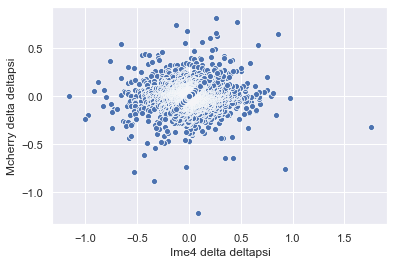

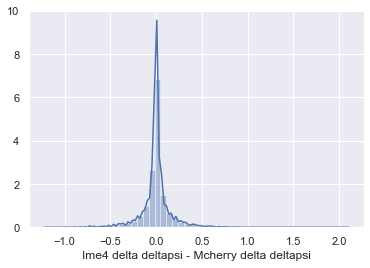

In [2]:
import os
os.chdir("/Users/kyang/bonini/stable571/majiq_analysis/src/")
from process_majiq import *
normalize()

# References

https://elifesciences.org/articles/11752

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5704921/